In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import sklearn


import warnings

In [72]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

# warnings.showwarning()

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/prvshnat/hsedata2425/refs/heads/main/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1338 non-null   int64  
 1   sex          1338 non-null   object 
 2   massIdx      1338 non-null   float64
 3   children     1338 non-null   int64  
 4   smoker       1338 non-null   object 
 5   region       1338 non-null   object 
 6   charges      1338 non-null   float64
 7   log_charges  1338 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 83.8+ KB


In [41]:
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
age,1338.000000,39.207025,14.049960,18.000000,27.000000,39.000000,51.000000,64.000000
massIdx,1338.000000,30.663397,6.098187,15.960000,26.296250,30.400000,34.693750,53.130000
children,1338.000000,1.094918,1.205493,0.000000,0.000000,1.000000,2.000000,5.000000
charges,1338.000000,13270.422265,12110.011237,1121.873900,4740.287150,9382.033000,16639.912515,63770.428010
log_charges,1338.000000,9.098659,0.919527,7.022756,8.463853,9.146552,9.719558,11.063045


In [4]:
df.rename(columns={'bmi': 'massIdx'}, inplace=True)

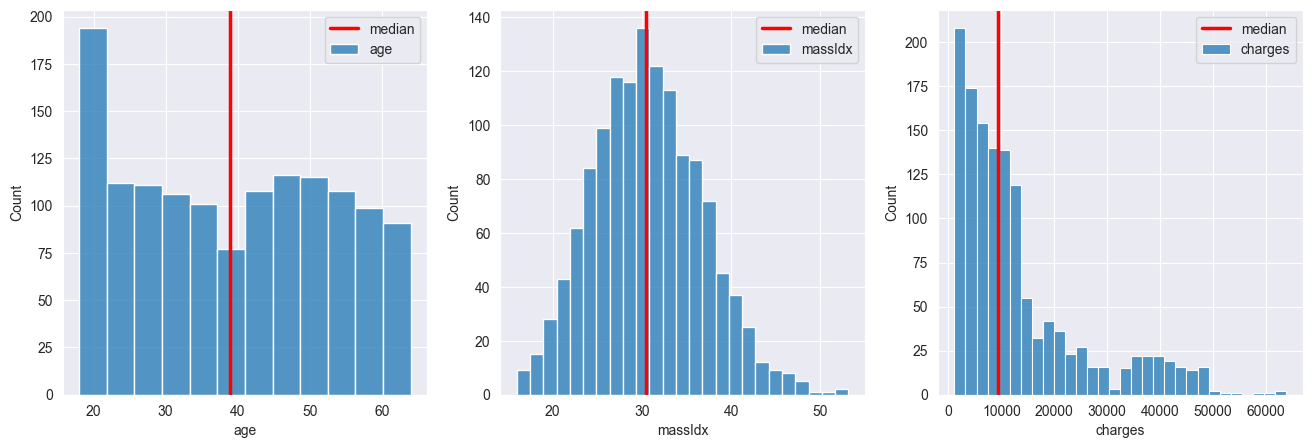

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

columns = ['age', 'massIdx', 'charges']

for i in range(len(columns)):
    sns.histplot(data=df, x=columns[i], ax=ax[i], label=columns[i])
    ax[i].set_label(columns[i])
    ax[i].axvline(df[columns[i]].median(), color='red', linewidth=2.5, label='median')
    # ax[i].axvline(df[columns[i]].mean(), color='yellow', linewidth=2.5)
    ax[i].legend()

In [22]:
df['log_charges'] = np.log(df['charges'])

In [32]:
df['log_charges'].var()

np.float64(0.8455301114153917)

In [ ]:
n_obj = 10**4

norm_rv = stats.norm(9, 1)

massive_values = norm_rv.rvs(size=n_obj)

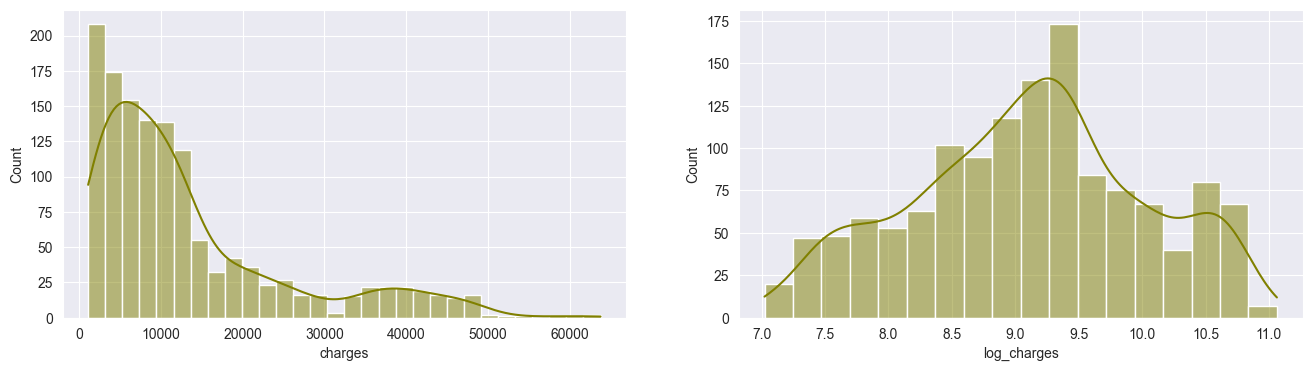

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

columns = ['charges', 'log_charges']

for i in range(len(columns)):
    sns.histplot(df[columns[i]], kde=True, ax=ax[i], color='olive')

In [73]:
IQR = 1.5*(df['massIdx'].quantile(0.75) - df['massIdx'].quantile(0.25))


C:\Users\levch\AppData\Local\Temp\ipykernel_17456\4117948605.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


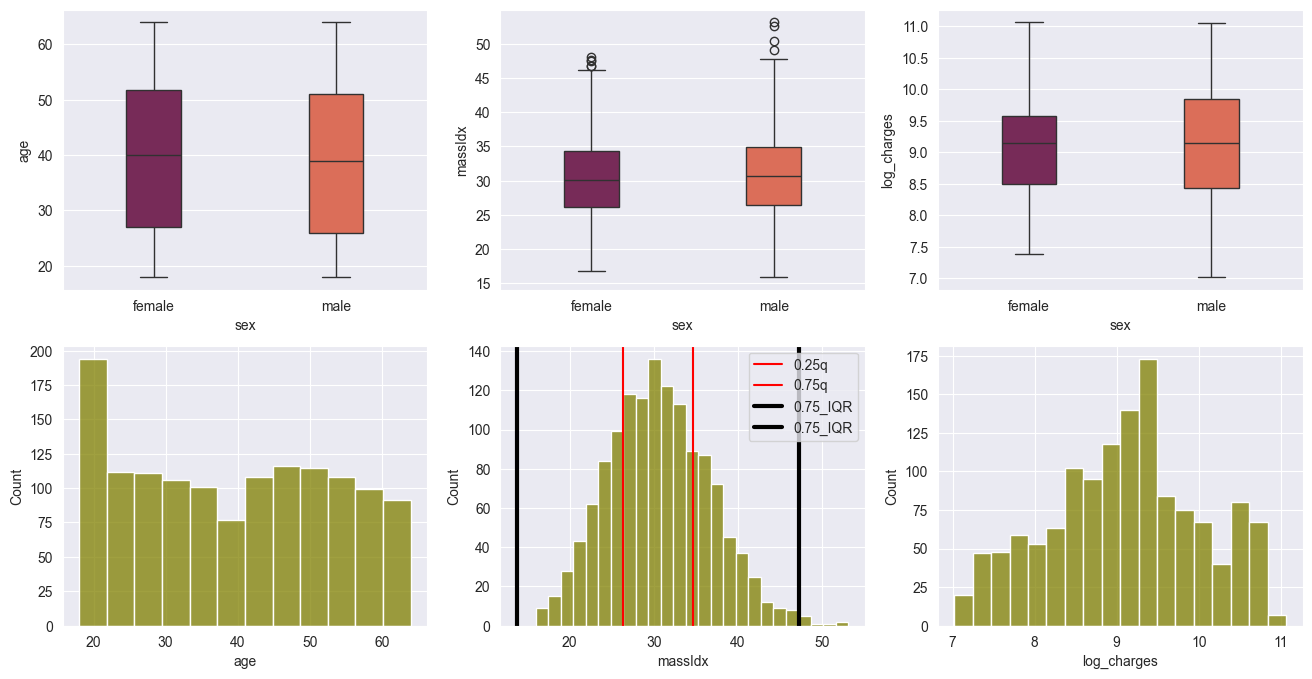

In [81]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

lst = ['age', 'massIdx', 'log_charges']

for i in range(len(lst)):
    sns.boxplot(x=df['sex'], y=df[lst[i]], hue=df['sex'], ax=ax[0, i], width=0.3, palette='rocket')
    # ax[i].set_title(lst[i])
    
    sns.histplot(df[lst[i]], ax=ax[1, i], color='olive')
    
    if lst[i] == 'massIdx':
        ax[1, i].axvline(df['massIdx'].quantile(0.25), color='red', label='0.25q')
        ax[1, i].axvline(df['massIdx'].quantile(0.75), color='red', label='0.75q')
        ax[1, i].axvline(x=df['massIdx'].quantile(0.75)+IQR, color='black', label='0.75_IQR', linewidth=3)
        ax[1, i].axvline(x=df['massIdx'].quantile(0.25)-IQR, color='black', label='0.75_IQR', linewidth=3)

        
    ax[1, 1].legend()

In [83]:
df = df[(df['massIdx'] < (df['massIdx'].quantile(0.75) + IQR)) & (df['massIdx'] > (df['massIdx'].quantile(0.25) - IQR))]

In [85]:
df2 = pd.get_dummies(df, columns=['sex', 'region', 'smoker'], dtype = int, drop_first=True) 
df2.head()

,age,massIdx,children,charges,log_charges,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19,27.900,0,16884.92400,9.734176,0,0,0,1,1
1,18,33.770,1,1725.55230,7.453302,1,0,1,0,0
2,28,33.000,3,4449.46200,8.400538,1,0,1,0,0
3,33,22.705,0,21984.47061,9.998092,1,1,0,0,0
4,32,28.880,0,3866.85520,8.260197,1,1,0,0,0


Мы хотим построить модель, которая будет предсказывать размер страховой премии, поэтому давайте посмотрим, на зависимости признаков от **log_charges**

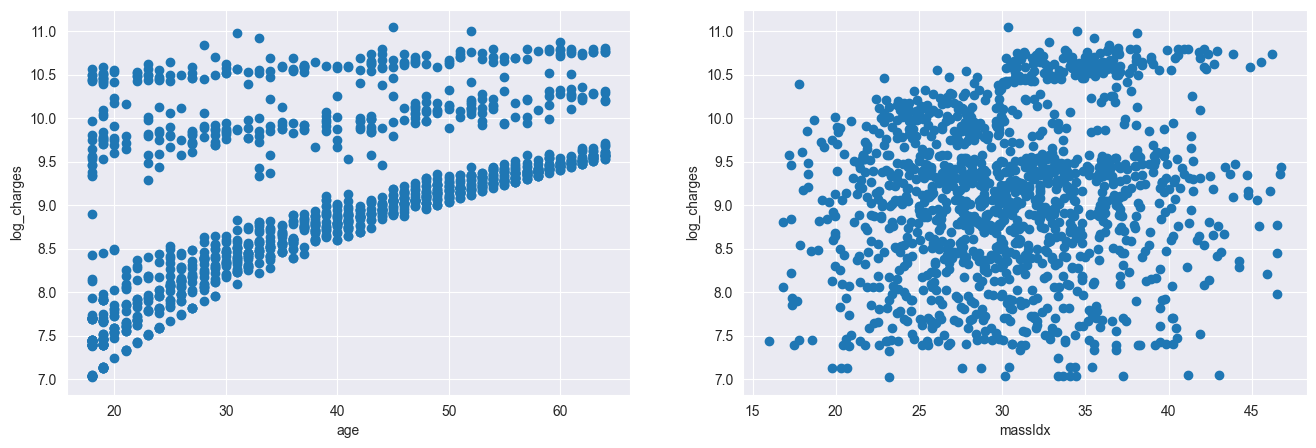

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

lst = ['age', 'massIdx']

for i in range(len(lst)):
    ax[i].scatter(df2[lst[i]], df2['log_charges'])
    ax[i].set_ylabel('log_charges')
    ax[i].set_xlabel(lst[i])

In [92]:
df2[['age', 'massIdx', 'log_charges']].corr().style.background_gradient(cmap='inferno')

,age,massIdx,log_charges
age,1.000000,0.114686,0.529323
massIdx,0.114686,1.000000,0.133912
log_charges,0.529323,0.133912,1.000000


<Axes: >

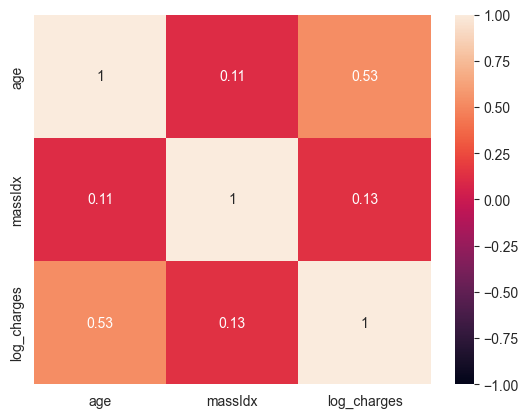

In [94]:
sns.heatmap(df2[['age', 'massIdx', 'log_charges']].corr(), vmin=-1, annot=True)

### Многофакторная регрессия

In [95]:
import statsmodels.api as sm

In [96]:
df2.columns

Index(['age', 'massIdx', 'children', 'charges', 'log_charges', 'sex_male',
       'region_northwest', 'region_southeast', 'region_southwest',
       'smoker_yes'],
      dtype='object')

In [108]:
X = sm.add_constant(df2[[column for column in df2.columns if columns not in ['charges', 'log_charges']]])
y = df2['log_charges']

In [109]:
model1 = sm.OLS(y, X).fit()

In [110]:
y_pred = model1.predict(X)
y_pred

0        9.734176
1        7.453302
2        8.400538
3        9.998092
4        8.260197
          ...    
1333     9.268661
1334     7.698927
1335     7.396233
1336     7.604867
1337    10.279914
Length: 1329, dtype: float64

In [105]:
print('R2', model1.rsquared.round(2))
print('MSE', round(sum((y-y_pred)**2)/len(y), 2))
print('MAE', round(sum(abs(y-y_pred))/len(y), 2))
print('F-statistic', model1.f_pvalue.round(2))

R2 1.0
MSE 0.0
MAE 0.0
F-statistic 0.0


### **Подход машинного обучения**

In [116]:
from sklearn.model_selection import train_test_split

X = df2[[column for column in df2.columns if columns not in ['charges', 'log_charges']]]
y = df2['log_charges']

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)

In [117]:
from sklearn.linear_model import LinearRegression

x_train = X_train[['age']]

lin_model1 = LinearRegression().fit(x_train, y_train)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = lin_model1.predict(X_test)

print()